In [1]:
import pandas as pd


df = pd.read_csv("uber_dataset.csv")


print(df.head())  


print(df.iloc[0])  # Shows only the first line of each column


  userName  userImage          content  score  thumbsUpCount  \
0   User_0        NaN             Good      5              0   
1   User_1        NaN             Nice      5              0   
2   User_2        NaN  Very convenient      5              0   
3   User_3        NaN             Good      4              0   
4   User_4        NaN         exllence      5              0   

  reviewCreatedVersion                   at replyContent repliedAt  \
0          4.556.10005  2024-12-18 17:17:19          NaN       NaN   
1          4.556.10005  2024-12-18 17:17:17          NaN       NaN   
2          4.532.10001  2024-12-18 17:09:42          NaN       NaN   
3          4.556.10005  2024-12-18 17:08:27          NaN       NaN   
4          4.556.10005  2024-12-18 17:08:16          NaN       NaN   

    appVersion  
0  4.556.10005  
1  4.556.10005  
2  4.532.10001  
3  4.556.10005  
4  4.556.10005  
userName                             User_0
userImage                               NaN
cont

In [7]:
df.columns = df.columns.str.strip().str.lower()  # Removes spaces & lowercases column names
print(df.columns)  # Check if "content" exists now


Index(['column1', 'column2', 'column3'], dtype='object')


In [15]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load dataset
df = pd.read_csv("uber_dataset.csv")
df.columns = df.columns.str.strip().str.lower()

# Check 'content' and 'score' columns
if "content" not in df.columns or "score" not in df.columns:
    raise KeyError("Required columns 'content' and/or 'score' are missing.")

# Step 1: Sentiment analysis using VADER
analyzer = SentimentIntensityAnalyzer()
df["sentiment_score"] = df["content"].astype(str).apply(lambda x: analyzer.polarity_scores(x)["compound"])

# Step 2: Map VADER scores to sentiment labels
def classify_sentiment(score):
    if score > 0.05:
        return "positive"
    elif score < -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_sentiment"] = df["sentiment_score"].apply(classify_sentiment)

# Step 3: Map star ratings to actual sentiment
def map_score_to_sentiment(star):
    if star >= 4:
        return "positive"
    elif star == 3:
        return "neutral"
    else:
        return "negative"

df["review_sentiment"] = df["score"].apply(map_score_to_sentiment)

# Step 4: Compare and check match
df["match"] = df["vader_sentiment"] == df["review_sentiment"]

# Step 5: Precision metrics
total = len(df)
matches = df["match"].sum()
accuracy = matches / total

print(f"✔ Total reviews analyzed: {total}")
print(f"✔ Matches between sentiment and score: {matches}")
print(f"✔ Accuracy of VADER sentiment vs. review score: {accuracy:.2%}")

# Optional: Save to CSV
df.to_csv("sentiment_vs_score.csv", index=False)


✔ Total reviews analyzed: 12000
✔ Matches between sentiment and score: 9509
✔ Accuracy of VADER sentiment vs. review score: 79.24%


In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Smaller and faster model
model_name = "siebert/sentiment-roberta-large-english"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create sentiment pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Example
print(sentiment_pipeline("I love using Uber. It’s so convenient!"))


Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9988749623298645}]


In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch

# Load the tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a pipeline
roberta_sentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Device set to use cpu


In [10]:


# Load your dataset
df = pd.read_csv("uber_dataset.csv")  # adjust to your file path
df = df.dropna(subset=["content"])     # drop rows without review text

# Filter for dynamic pricing-related reviews (optional but recommended)
pricing_keywords = ["surge", "price", "pricing", "expensive", "fare", "cost"]
df_filtered = df[df["content"].str.contains('|'.join(pricing_keywords), case=False, na=False)]

# Run RoBERTa sentiment analysis
def get_sentiment(text):
    try:
        result = roberta_sentiment(text[:512])  # truncate long texts
        return result[0]['label'], result[0]['score']
    except Exception as e:
        return None, None

# Apply to reviews
df_filtered[['sentiment', 'confidence']] = df_filtered['content'].apply(lambda x: pd.Series(get_sentiment(x)))

# Show sample output
print(df_filtered[['content', 'sentiment', 'confidence']].head())


                                              content sentiment  confidence
6                         Bast price pr car available   LABEL_1    0.805703
18  Quote you one price and charge you another (hi...   LABEL_1    0.766978
28  Horrible, bunch of thieves. The fare you see w...   LABEL_0    0.964689
40                 Good price Easy to use application   LABEL_2    0.891229
71  Rates are actually too high 😔 sometimes I feel...   LABEL_0    0.884913


C:\Users\omarr\AppData\Local\Temp\ipykernel_28840\1198200572.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['sentiment', 'confidence']] = df_filtered['content'].apply(lambda x: pd.Series(get_sentiment(x)))
C:\Users\omarr\AppData\Local\Temp\ipykernel_28840\1198200572.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['sentiment', 'confidence']] = df_filtered['content'].apply(lambda x: pd.Series(get_sentiment(x)))


In [17]:

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Load dataset
df = pd.read_csv('uber_dataset.csv')

# Map score (1 to 5) to 3 sentiment classes: 0=neg,1=neu,2=pos
def score_to_label(score):
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['label'] = df['score'].apply(score_to_label)

# Load RoBERTa sentiment model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()
    return pred

# Predict sentiment for all reviews
predictions = []
for review in tqdm(df['content'], desc="Predicting"):
    pred = predict_sentiment(review)
    predictions.append(pred)

df['pred_label'] = predictions

# Calculate accuracy
accuracy = (df['label'] == df['pred_label']).mean()
print(f"RoBERTa sentiment classification accuracy: {accuracy * 100:.2f}%")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Predicting: 100%|██████████| 12000/12000 [10:09<00:00, 19.68it/s]

RoBERTa sentiment classification accuracy: 86.37%


In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Load your dataset
df = pd.read_csv('uber_dataset.csv')

# Define pricing-related keywords (case insensitive)
pricing_keywords = [
    "price", "pricing", "cost", "fare", "expensive", "cheap", 
    "rate", "surge", "dynamic pricing", "price hike", "price increase",
    "pricing model", "costly", "overpriced", "discount", "promo"
]

# Filter reviews that mention any pricing-related keywords
def contains_pricing_terms(text):
    text_lower = str(text).lower()
    return any(keyword in text_lower for keyword in pricing_keywords)

df_pricing = df[df['content'].apply(contains_pricing_terms)].copy()
print(f"Found {len(df_pricing)} reviews mentioning pricing-related terms.")

# Load RoBERTa sentiment model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Predict sentiment function
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()
    return pred

# Predict sentiment for pricing-related reviews
predictions = []
for review in tqdm(df_pricing['content'], desc="Predicting pricing sentiment"):
    pred = predict_sentiment(review)
    predictions.append(pred)

df_pricing['sentiment_label'] = predictions

# Map sentiment labels to text for clarity
sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df_pricing['sentiment_text'] = df_pricing['sentiment_label'].map(sentiment_map)

# Optionally balance the dataset by sampling equal numbers of each sentiment (if needed)
min_count = df_pricing['sentiment_text'].value_counts().min()
balanced_df = pd.concat([
    df_pricing[df_pricing['sentiment_text'] == label].sample(min_count, random_state=42)
    for label in sentiment_map.values()
])

# Show counts
print("Sentiment distribution on pricing-related reviews:")
print(df_pricing['sentiment_text'].value_counts())

# Save or display results
balanced_df.to_csv("pricing_sentiment_balanced.csv", index=False)
print("Saved balanced pricing sentiment dataset to 'pricing_sentiment_balanced.csv'.")

# If you want to see a sample of reviews with sentiment:
print(balanced_df[['content', 'sentiment_text']].head(10))


Found 1093 reviews mentioning pricing-related terms.


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Predicting pricing sentiment: 100%|██████████| 1093/1093 [02:18<00:00,  7.88it/s]


Sentiment distribution on pricing-related reviews:
sentiment_text
Negative    580
Positive    350
Neutral     163
Name: count, dtype: int64
Saved balanced pricing sentiment dataset to 'pricing_sentiment_balanced.csv'.
                                                 content sentiment_text
11889  I am not sure what has taken place the past mo...       Negative
5090   Ubers prices feels "made up as we go" I unders...       Negative
2408   after the end of the ride , when I was getting...       Negative
3518   Unable to turn off push notifications for "pro...       Negative
9076   The rates are going much higher nowadays plz c...       Negative
5255   The cost of a ride has gotten ridiculous and e...       Negative
10717  I am a daily customer of uber but now i have n...       Negative
8621   Would give less if able, constantly cancel and...       Negative
3374   If you look at how long a ride will take to ge...       Negative
4557   I see Uber is price gauging yet again, $12-$18...      

Found 1470 reviews mentioning pricing-related terms.


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Predicting pricing sentiment: 100%|██████████| 1470/1470 [02:02<00:00, 12.02it/s]


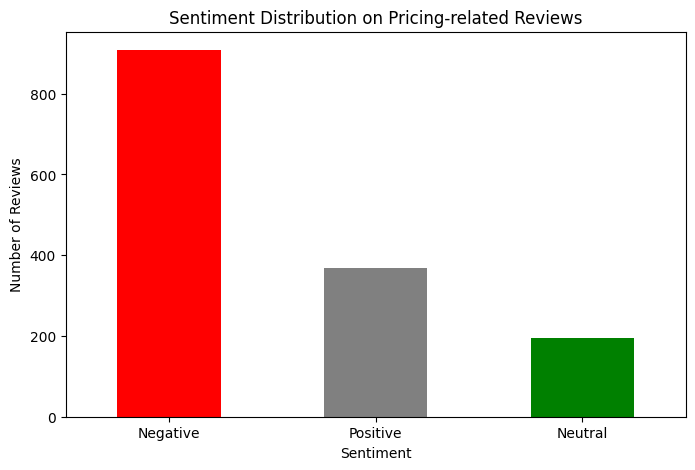

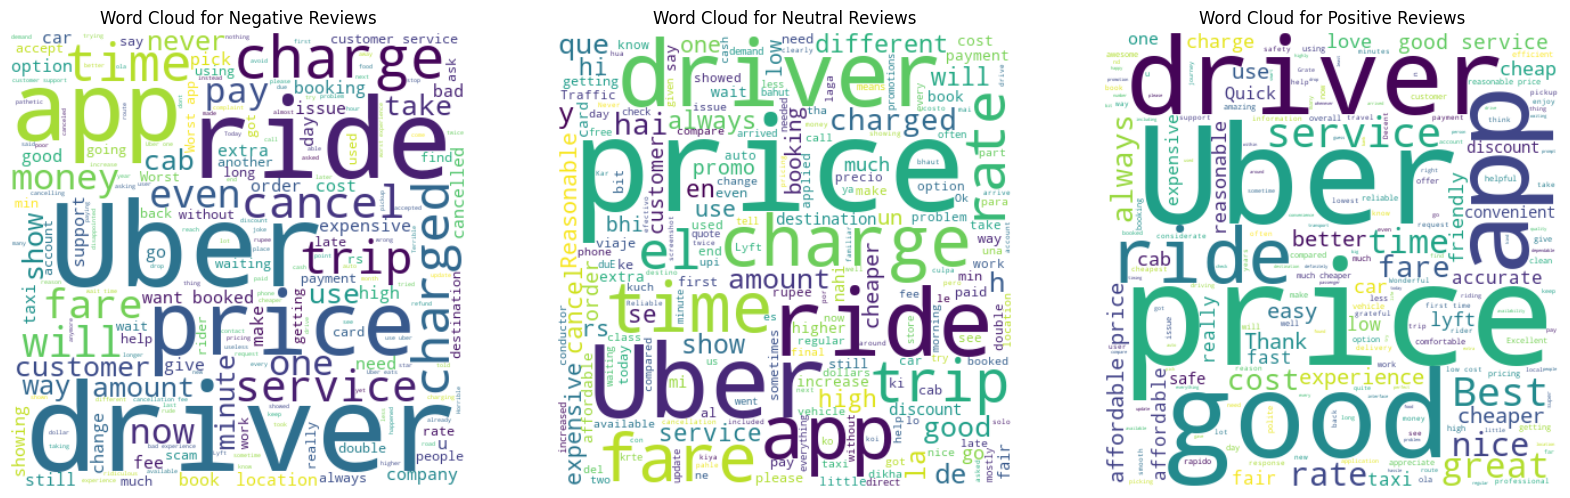

Sentiment counts on pricing-related reviews:
sentiment_text
Negative    908
Positive    368
Neutral     194
Name: count, dtype: int64


In [4]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load dataset
df = pd.read_csv('uber_dataset.csv')

# Expanded pricing-related keywords
pricing_keywords = [
    "price", "pricing", "cost", "fare", "expensive", "cheap", "rate", "surge", "dynamic pricing",
    "price hike", "price increase", "pricing model", "costly", "overpriced", "discount", "promo",
    "fees", "cancellation fee", "minimum fare", "trip cost", "charge", "charged", "billing",
    "expensiveness", "expensively", "low cost", "expensive ride", "surge pricing", "peak pricing",
    "pricing strategy", "taxi fare", "waiting charge", "waiting fee", "ride cost"
]

def contains_pricing_terms(text):
    text_lower = str(text).lower()
    return any(keyword in text_lower for keyword in pricing_keywords)

# Filter pricing-related reviews
df_pricing = df[df['content'].apply(contains_pricing_terms)].copy()
print(f"Found {len(df_pricing)} reviews mentioning pricing-related terms.")

# Load model & tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()
    return pred

# Predict sentiment
predictions = []
for review in tqdm(df_pricing['content'], desc="Predicting pricing sentiment"):
    predictions.append(predict_sentiment(review))

df_pricing['sentiment_label'] = predictions

# Map labels to text
sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df_pricing['sentiment_text'] = df_pricing['sentiment_label'].map(sentiment_map)

# Plot sentiment distribution
plt.figure(figsize=(8,5))
counts = df_pricing['sentiment_text'].value_counts()
counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title("Sentiment Distribution on Pricing-related Reviews")
plt.ylabel("Number of Reviews")
plt.xlabel("Sentiment")
plt.xticks(rotation=0)
plt.show()

# Generate word clouds for each sentiment
plt.figure(figsize=(20,6))

for i, sentiment in enumerate(['Negative', 'Neutral', 'Positive']):
    plt.subplot(1, 3, i+1)
    text = " ".join(df_pricing[df_pricing['sentiment_text'] == sentiment]['content'].astype(str))
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {sentiment} Reviews")
    plt.axis('off')

plt.show()

# Print counts of each sentiment category
sentiment_counts = df_pricing['sentiment_text'].value_counts()
print("Sentiment counts on pricing-related reviews:")
print(sentiment_counts)


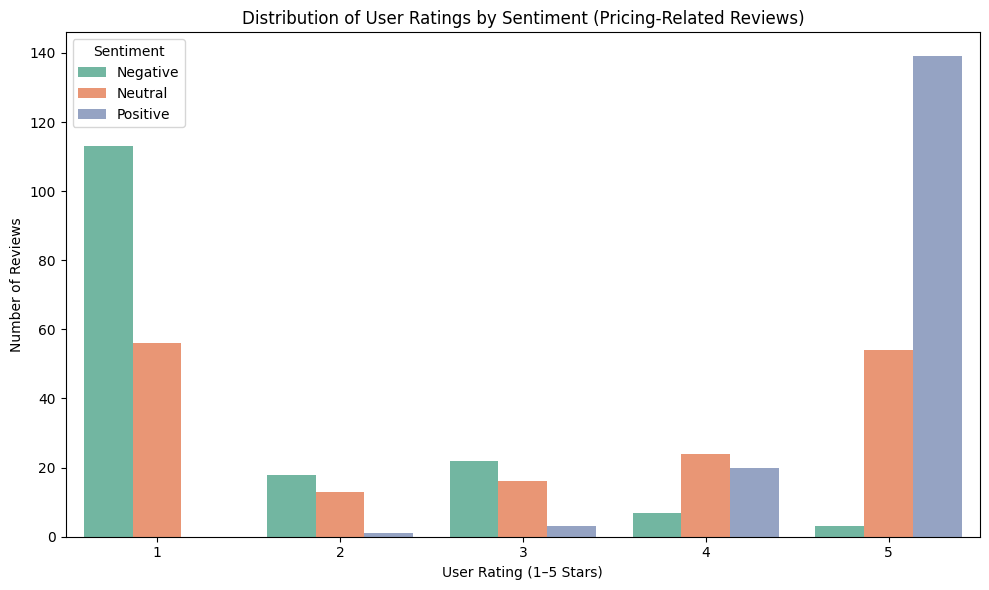

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your pricing sentiment dataset
df = pd.read_csv("pricing_sentiment_balanced.csv")  # Adjust path if needed

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='score', hue='sentiment_text', palette='Set2')
plt.title('Distribution of User Ratings by Sentiment (Pricing-Related Reviews)')
plt.xlabel('User Rating (1–5 Stars)')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from tqdm import tqdm

# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, from_flax=True)
model.eval()

# Load data
df = pd.read_csv("uber_dataset.csv")
df = df[df['content'].notna()]  # Remove NaNs

# Sentiment prediction function
def get_sentiment(text):
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = softmax(output.logits.numpy()[0])
    sentiments = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
    return sentiments[scores.argmax()]

# Keywords
pricing_keywords = r"\b(price|expensive|cheap|cost|fare|surge|pricing|too much)\b"
loyalty_keywords = r"\b(loyal|always use|every time|regular|frequent)\b"
brand_keywords = r"\b(trust|reliable|unprofessional|quality|image|reputation)\b"

# Tagging and sentiment
pricing_sentiments = []
loyalty_sentiments = []
brand_sentiments = []

sample_df = df.sample(1000, random_state=42)  # Use sample to keep runtime low

for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    review = str(row['content']).lower()
    sentiment = get_sentiment(review).tensor.cpu()

    if re.search(pricing_keywords, review):
        pricing_sentiments.append(sentiment)
    if re.search(loyalty_keywords, review):
        loyalty_sentiments.append(sentiment)
    if re.search(brand_keywords, review):
        brand_sentiments.append(sentiment)

# Function to print sentiment distribution
from collections import Counter

def display_distribution(label, sentiment_list):
    total = len(sentiment_list)
    print(f"\n{label} Sentiment Distribution (n={total}):")
    dist = Counter(sentiment_list)
    for k in ['POSITIVE', 'NEUTRAL', 'NEGATIVE']:
        count = dist.get(k, 0)
        print(f"{k}: {count} ({100*count/total:.2f}%)")

# Output
display_distribution("Pricing", pricing_sentiments)
display_distribution("Customer Loyalty", loyalty_sentiments)
display_distribution("Brand Image", brand_sentiments)


c:\Users\omarr\Downloads\archive (4)\myenv\Lib\site-packages\transformers\modeling_flax_pytorch_utils.py:453: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  pt_model_dict[flax_key] = torch.from_numpy(flax_tensor)
c:\Users\omarr\Downloads\archive (4)\myenv\Lib\site-packages\torch\nn\modules\module.py:2409: UserWarning: for roberta.embeddings.word_embeddings.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in 

TypeError: can't convert meta device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.